<a href="https://colab.research.google.com/github/fedrik67/drowdiness_detection/blob/main/mixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
path = kagglehub.dataset_download('serenaraju/yawn-eye-dataset-new')

print('Data source import complete.')

100%|██████████| 161M/161M [00:03<00:00, 54.3MB/s]

Extracting model files...


Data source import complete.


Downloaded data from the kaggle repository and imports all the necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob as gb
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import os

generating the path of files.

In [ ]:
data_training = path+'/dataset_new/train/'
data_test = path+'/dataset_new/test/'
data_training

'/root/.cache/kagglehub/datasets/serenaraju/yawn-eye-dataset-new/versions/1/dataset_new/train/'

labels

In [ ]:
code = {'Open':0, 'no_yawn':1, 'yawn':2, 'Closed':3 }
def getcode(n) :
    for x , y in code.items() :
        if n == y :
            return x

checking the number of files in each categories

In [ ]:
for folder in  os.listdir(data_training):
    files = gb.glob(pathname= str( data_training + folder + '/*.jpg'))
    print(f'For data , found {len(files)} in folder {folder}')
    print({folder})

For data , found 617 in folder Open
{'Open'}
For data , found 617 in folder yawn
{'yawn'}
For data , found 617 in folder Closed
{'Closed'}
For data , found 616 in folder no_yawn
{'no_yawn'}


This code snippet reads images from different folders, resizes them to a consistent size, and then organizes them into separate lists based on whether they represent eye state or yawning, along with their corresponding labels. This organized data is then ready for use in training a machine learning model to classify eye state and yawning.

In [ ]:
s = 140 # new size of image
X_eye = []
X_yawn = []

y_eye = []
y_yawn = []

for folder in  os.listdir(data_training) :
        files = gb.glob(pathname= str( data_training + folder + '/*.jpg'))

        print(f'For data , found {len(files)} in folder {folder}')
        print({folder})
        # print(files)
        for file in files:
            image = cv2.imread(file)
            image_array = cv2.resize(image , (s,s))
            if folder == 'Open' or folder == 'Closed':
              X_eye.append(list(image_array))
              y_eye.append(code[folder])
            else:
              X_yawn.append(list(image_array))
              y_yawn.append(code[folder])


For data , found 617 in folder Open
{'Open'}
For data , found 617 in folder yawn
{'yawn'}
For data , found 617 in folder Closed
{'Closed'}
For data , found 616 in folder no_yawn
{'no_yawn'}


This code snippet is responsible for combining the data for eye state and yawning into single training datasets.

In [ ]:
X_Train = []
y_Train = []
X_Train.extend(X_eye)
X_Train.extend(X_yawn)
y_Train = y_eye
y_Train.extend(y_yawn)

len(X_Train)

2467

This code snippet is responsible for creating the test dataset (X_test and y_test) that will be used to evaluate the performance of the machine learning model. It reads images from the test data directory, resizes them, and stores them in these arrays.

In [ ]:
X_test = []
y_test = []
for folder in  os.listdir(data_test) :
        files = gb.glob(pathname= str( data_test + folder + '/*.jpg'))
        for file in files:
            image = cv2.imread(file)
            image_array = cv2.resize(image , (s,s))
            X_test.append(list(image_array))
            y_test.append(code[folder])
len(X_test)


433

taking random photo from the dataset and viewing it with labels as titles.

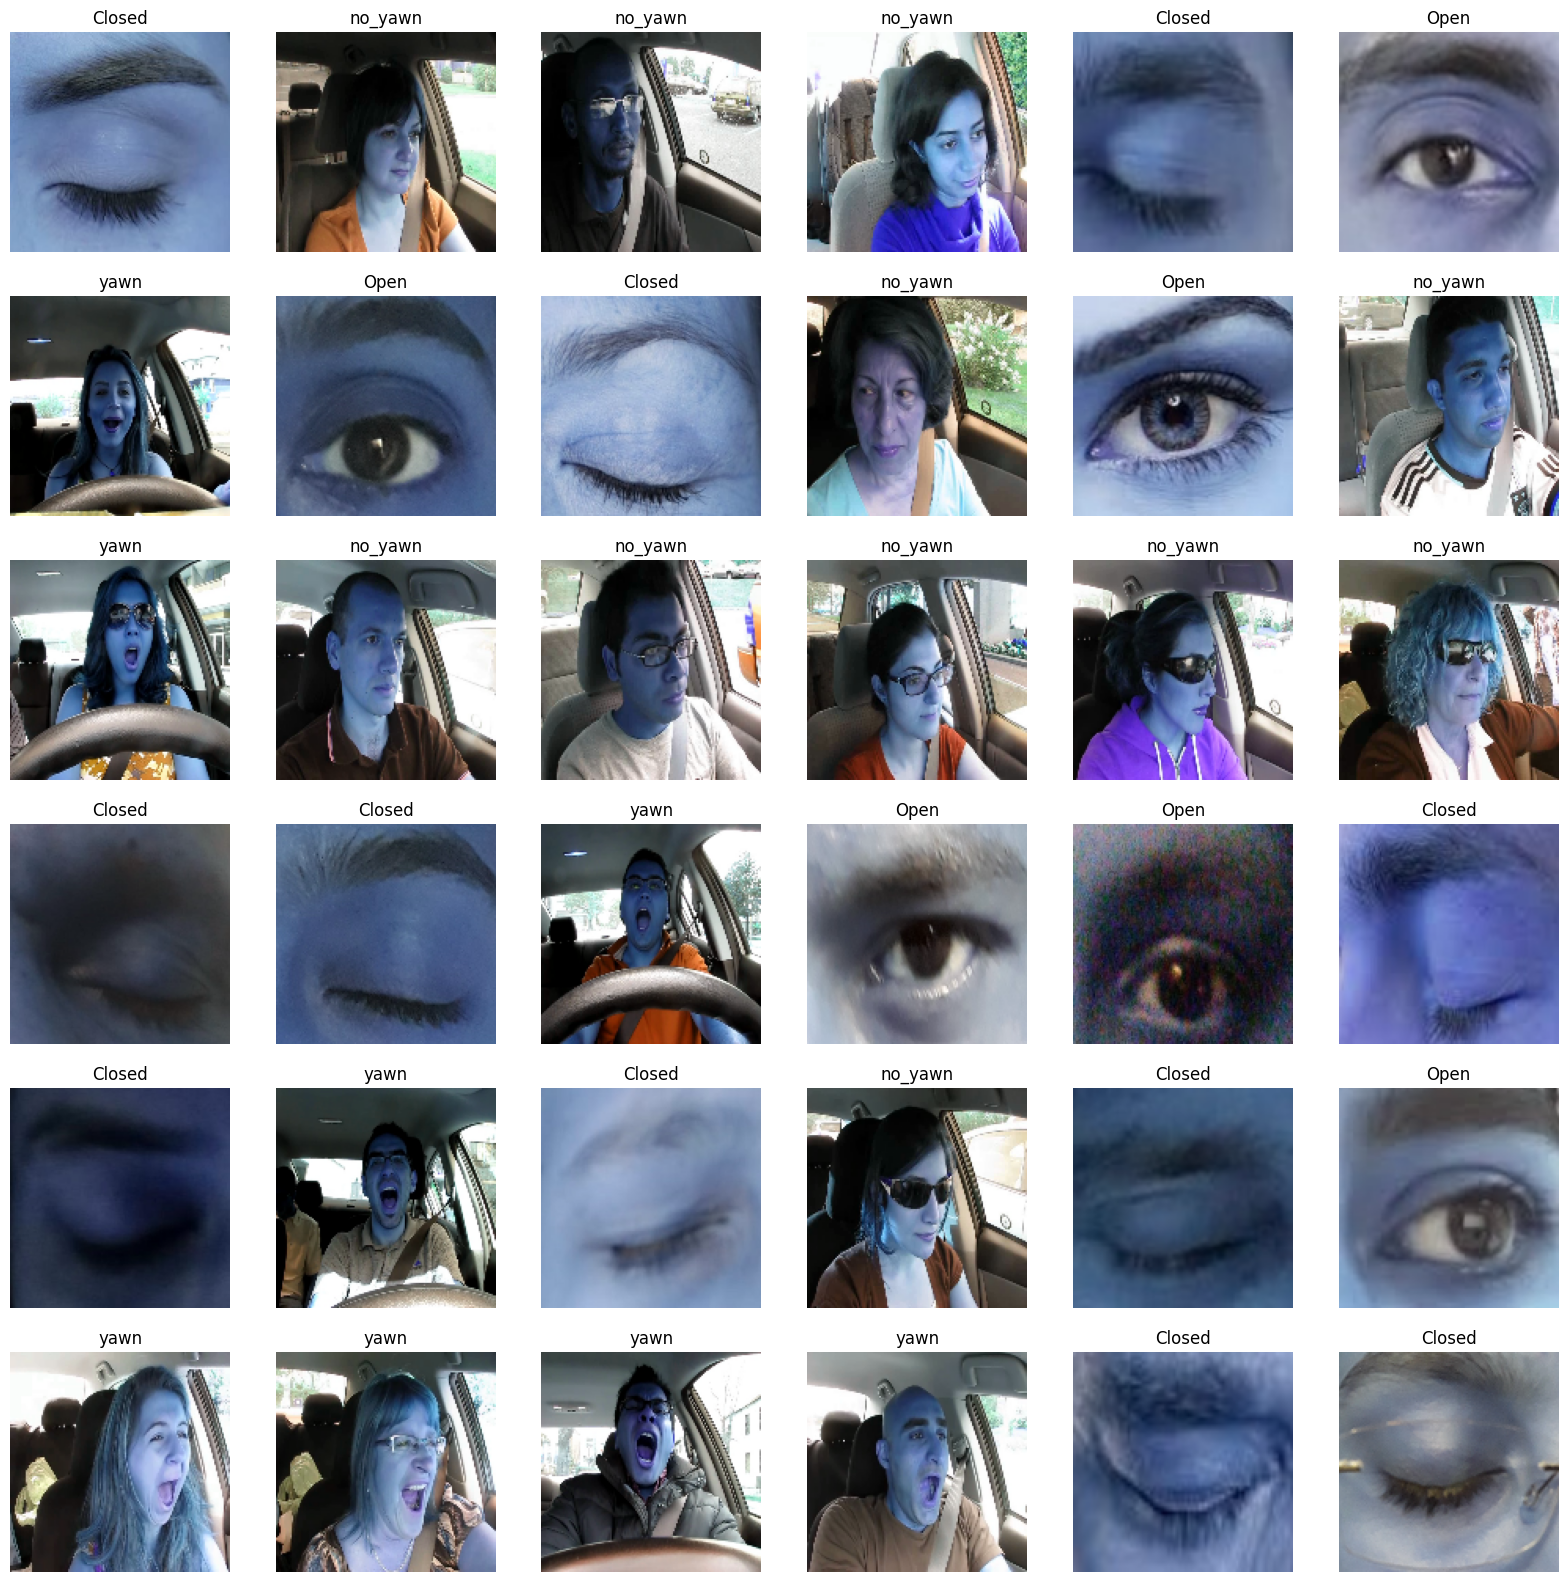

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_Train),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(X_Train[i])
    plt.axis('off')
    plt.title(getcode(y_Train[i]))

This code uses the train_test_split function from the sklearn.model_selection module.
Its purpose is to divide the training data (X_Train, y_Train) into two subsets: a training set (X_train, y_train) and a validation set (X_val, y_val).
train_size=0.7 means that 70% of the data will be used for training, and the remaining 30% will be used for validation.
shuffle=True indicates that the data will be randomly shuffled before splitting.
random_state=0 ensures that the shuffling is reproducible, meaning you'll get the same split every time you run the code.


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_Train, y_Train, train_size=0.7, shuffle=True, random_state=0)

from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()

X_train = np.array(X_train)
y_train = label_bin.fit_transform(y_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = label_bin.fit_transform(y_val)
y_val = np.array(y_val)
print(y_val.shape)
temp2 = list(zip(X_test, y_test))
random.shuffle(temp2)
X_test, y_test = zip(*temp2)
X_test = np.array(X_test)
y_test = label_bin.fit_transform(y_test)
y_test = np.array(y_test)

(741, 4)


This part defines the structure of a Convolutional Neural Network (CNN) using the Keras library.
Explanation:

model = Sequential(): This line initializes a Sequential model in Keras. A Sequential model is a linear stack of layers, meaning layers are added one after the other.

Conv2D Layers: These layers perform the convolution operation, which is a fundamental step in CNNs.

32, 64, 128, 256: These numbers represent the number of filters (or kernels) used in each Conv2D layer. Filters extract different features from the input image.
kernel_size=(3,3) or kernel_size=(5,5): This defines the size of the filter.
activation='relu' : This specifies the activation function, Rectified Linear Unit (ReLU), which introduces non-linearity into the model.
input_shape=(s,s,3): This is only present in the first Conv2D layer and defines the shape of the input images. s likely represents the image size (e.g., 140x140), and 3 indicates the image has 3 color channels (RGB).
MaxPooling2D Layers: These layers reduce the spatial dimensions of the feature maps (output from Conv2D layers). This helps to reduce computation and make the model more robust to variations in the input.

(2,2): This defines the size of the pooling window.
Flatten(): This layer converts the multi-dimensional feature maps into a single, long vector. This is necessary before connecting to the fully connected layers.

Dense Layers: These are fully connected layers, where each neuron is connected to every neuron in the previous layer.

512, 256, 128: These numbers represent the number of neurons in each Dense layer.
activation='relu' : ReLU activation is used here as well.


In [ ]:
model = Sequential([
        Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(s,s,3)),
        Conv2D(32,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64,kernel_size=(5,5),activation='relu'),
        Conv2D(64,kernel_size=(5,5),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128,kernel_size=(5,5),activation='relu'),
        Conv2D(128,kernel_size=(5,5),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(256,kernel_size=(3,3),activation='relu'),
        Conv2D(256,kernel_size=(3,3),activation='relu'),
        Flatten() ,


        Dense(512,activation='relu') ,
        Dense(256,activation='relu') ,

        Dense(128,activation='relu') ,

        ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


This code adds one more layer to the model with 4 neurons since there are 4  labels.Then it uses optimizers to mitigate loss and give a summary of all the model.

In [ ]:

model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 138, 138, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 136, 136, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 68, 68, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 26, 26, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 22, 22, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 9, 9, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,251,556 (31.48 MB)

 Trainable params: 8,251,556 (31.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train.shape

(1726, 140, 140, 3)

In [ ]:
y_test.shape

(433, 4)

 Here the Convolutional Neural Network (CNN), defined earlier in the code, learns to classify images.

epochs = 30:

This line sets the epochs variable to 30.
In machine learning, an epoch refers to one complete pass of the entire training dataset through the model.
Setting epochs to 30 means the model will be trained on the entire training dataset 30 times.

This is the key line where the training happens. The model.fit() function is used to train the Keras model. Let's examine the arguments passed to this function:
X_train, y_train: These are the training data and corresponding labels. The model learns to map the input data (X_train) to the correct output labels (y_train).
batch_size=64: This controls the number of training samples processed before the model's internal parameters are updated. A batch size of 64 means the model will update its weights after seeing 64 images.
epochs=epochs: This sets the number of epochs (training cycles) using the value assigned to the epochs variable (30 in this case).
validation_data=(X_val, y_val): This specifies the validation dataset (X_val, y_val). The model's performance is evaluated on this dataset after each epoch to monitor how well it's generalizing to unseen data. This helps prevent overfitting (where the model performs well on training data but poorly on new data).
validation_steps=len(X_train)//64: This determines the number of batches of validation data used in each epoch. Here, it's set to the length of the training data divided by the batch size.
verbose=1: This controls the amount of information displayed during training. A value of 1 provides progress updates after each epoch.

In [ ]:
epochs = 30
ThisModel = model.fit(X_train,y_train,batch_size=64, epochs=epochs,
                                     validation_data=(X_val,y_val), validation_steps=len(X_train)//64, verbose=1)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.3180 - loss: 5.4098 - val_accuracy: 0.6235 - val_loss: 0.9076
Epoch 2/30
 1/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6250 - loss: 0.8580

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6733 - loss: 0.7868 - val_accuracy: 0.6626 - val_loss: 0.6434
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6869 - loss: 0.5987 - val_accuracy: 0.7773 - val_loss: 0.5423
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7450 - loss: 0.5361 - val_accuracy: 0.7760 - val_loss: 0.5503
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7476 - loss: 0.4266 - val_accuracy: 0.7908 - val_loss: 0.4022
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8004 - loss: 0.3703 - val_accuracy: 0.8138 - val_loss: 0.3736
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8035 - loss: 0.3586 - val_accuracy: 0.8273 - val_loss: 0.3208
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8290 - loss: 0.3224 - val_accuracy: 0.8070 - val_loss: 0.4073
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8011 - loss: 0.3878 - val_accuracy: 0.8475 - val_

This code evaluates the trained CNN model on the test data, providing insights into its performance by displaying the loss and accuracy metrics.

In [ ]:
ModelLoss, ModelAccuracy = model.evaluate(X_test, y_test,batch_size=64)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9664 - loss: 0.1201
Test Loss is 0.12754833698272705
Test Accuracy is 0.9653579592704773


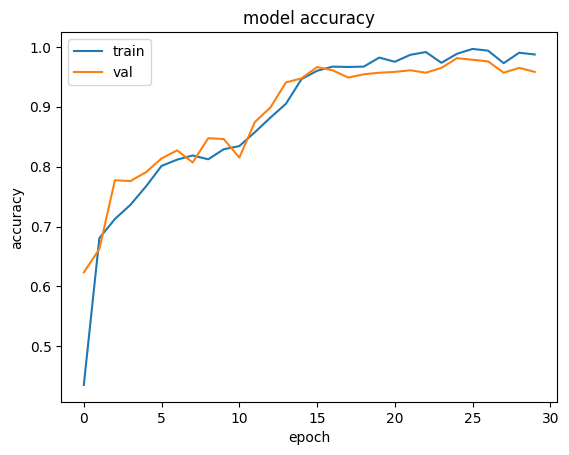

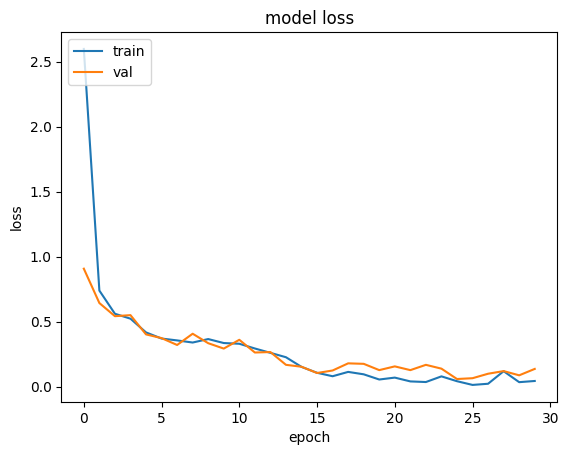

In [ ]:

# summarize model for accuracy
plt.plot(ThisModel.history['accuracy'])
plt.plot(ThisModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize model for loss
plt.plot(ThisModel.history['loss'])
plt.plot(ThisModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

This code snippet focuses on using the trained model (model) to make predictions on the test data (X_test) and then preparing the predictions and actual labels for further analysis.

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(y_pred)
pred = [np.argmax(x) for x in y_pred]
y_test_new = []
y_test_new = [np.argmax(x) for x in y_test]
print('Prediction Shape is {}'.format(y_pred.shape))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
[[1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 ...
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]]
Prediction Shape is (433, 4)


This code snippet calculates and visualizes the confusion matrix to evaluate the performance of the trained machine learning model.

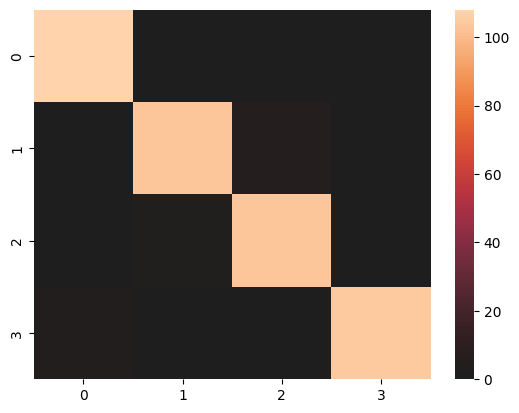

Confusion Matrix is
 [[108   0   0   1]
 [  0 103   6   0]
 [  0   3 103   0]
 [  5   0   0 104]]


In [ ]:
CM = confusion_matrix(y_test_new, pred)

sns.heatmap(CM, center=True)
plt.show()

print('Confusion Matrix is\n', CM)


This lines calculates and prints a report containing metrics like precision, recall, F1-score, and support for each class in the classification problem.
The second line simply calculates and prints the overall accuracy of the model, which is the percentage of correctly classified instances out of the total test instances.

In [ ]:
print(classification_report(y_test_new, pred))
print(accuracy_score(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       109
           1       0.97      0.94      0.96       109
           2       0.94      0.97      0.96       106
           3       0.99      0.95      0.97       109

    accuracy                           0.97       433
   macro avg       0.97      0.97      0.97       433
weighted avg       0.97      0.97      0.97       433

0.9653579676674365


Here we prints randomly the test dataset with predicted labels

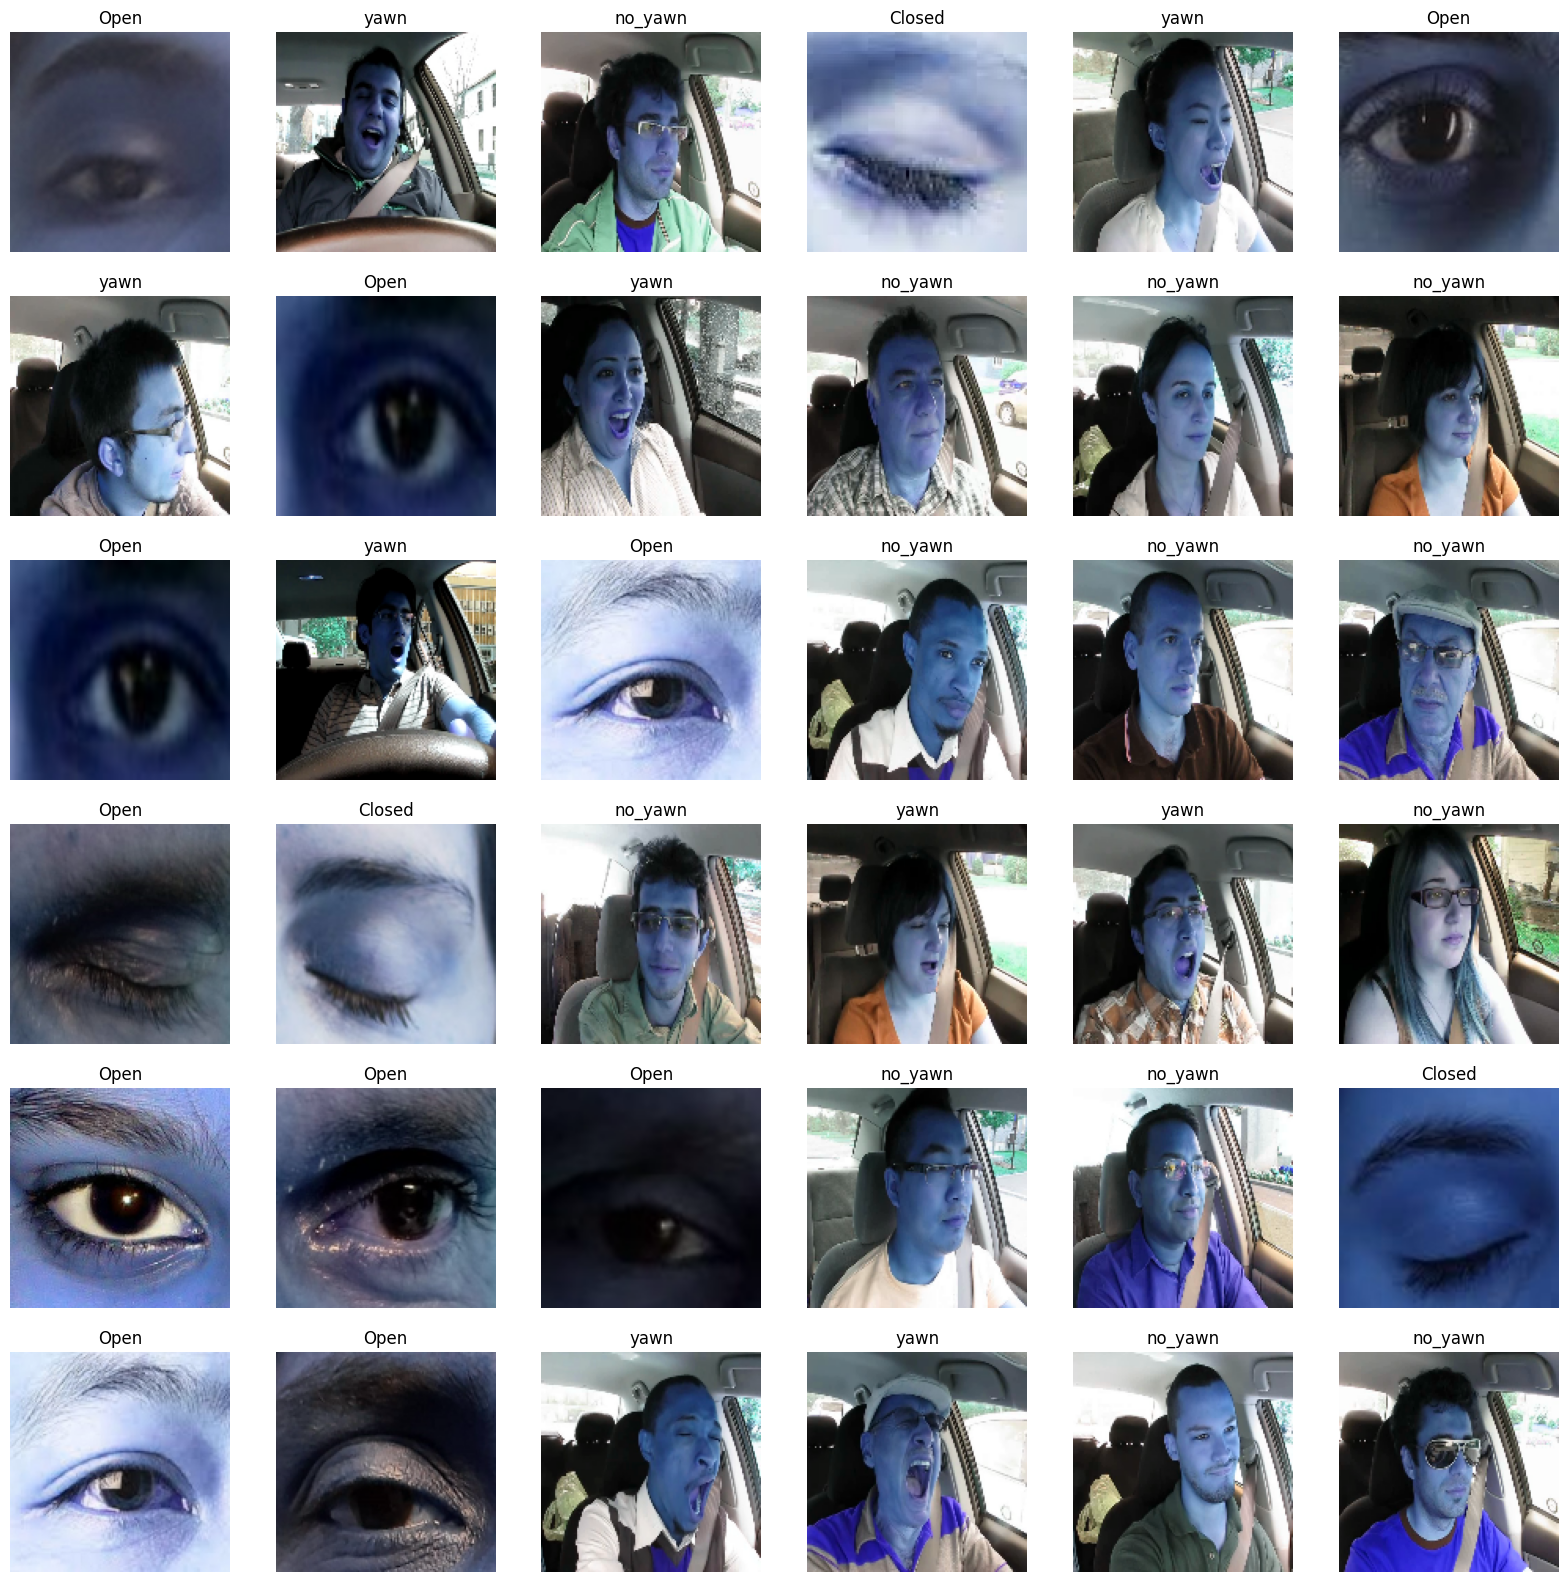

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_test),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(getcode(pred[i]))

This line is using the save() method which is built into Keras models. It's designed to store the entire trained model into a file.

In [ ]:
model.save('driver_state_original_mixed_wd.h5')